By Rio Aguina-Kang

Much of this notebook is taken from https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LLaVa/Fine_tune_LLaVa_on_a_custom_dataset_(with_PyTorch_Lightning).ipynb

In [53]:
MAX_LENGTH = 384
MODEL_ID = "llava-hf/llava-1.5-7b-hf"
# REPO_ID = ""
WANDB_PROJECT = "LLaVa"
WANDB_NAME = "llava-demo-pokemon"
IMAGE_DIR = 'real_pokemon_data/images'

## Load dataset & Models

In [54]:
import json

# Function to load JSON data
def load_json(json_path: str):
    """
    Load a JSON file.
    
    Args:
        json_path (str): Path to the JSON file.
        
    Returns:
        List[Dict]: Loaded JSON data as a list of dictionaries.
    """
    with open(json_path, 'r') as file:
        return json.load(file)

# Load the train, validation, and test JSONs
train_data = load_json('real_pokemon_data/train/dataset.json')
val_data = load_json('real_pokemon_data/validation/dataset.json')
test_data = load_json('real_pokemon_data/test/dataset.json')


In [55]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right" # during training, one always uses padding on the right

In [6]:
from transformers import BitsAndBytesConfig, LlavaForConditionalGeneration
import torch

USE_LORA = False
USE_QLORA = True

## Load model

# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
if USE_QLORA or USE_LORA:
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
        )
    model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        quantization_config=bnb_config,
    )
else:
    # for full fine-tuning, we can speed up the model using Flash Attention
    # only available on certain devices, see https://github.com/Dao-AILab/flash-attention?tab=readme-ov-file#installation-and-features
    model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2",
    )

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model


def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['multi_modal_projector', 'vision_model']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=find_all_linear_names(model),
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

## Make pytorch dataset

In [8]:
import os
import cv2
from torch.utils.data import Dataset
from typing import List, Dict, Tuple

class LlavaDataset(Dataset):
    """
    PyTorch Dataset for LLaVa. This class takes a JSON dataset with conversations as input.

    Each row consists of an image path and associated Q&A pairs.
    """

    def __init__(self, json_data: List[Dict]):
        """
        Args:
            json_data (List[Dict]): Loaded JSON data, where each entry contains `image` and `conversations`.
        """
        super().__init__()
        self.data = json_data
        self.dataset_length = len(self.data)

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[str, str]:
        """
        Returns one item of the dataset.

        Returns:
            image (str): The path to the image file.
            target_sequence (str): The ground truth sequence (Pokémon type answer).
        """
        sample = self.data[idx]

        # Extract image path
        image_fn = sample["image"]

        image_path = os.path.join(IMAGE_DIR, image_fn)
        # print(image_path)

        image = cv2.imread(image_path)

        # Extract the Pokémon type answer from conversations
        target_sequence = ""
        for conversation in sample["conversations"]:
            if conversation["from"] == "gt":  # Extract ground truth answer
                target_sequence = conversation["value"]
                break

        return image, target_sequence

In [9]:
# Create PyTorch Datasets for train, validation, and test
train_dataset = LlavaDataset(train_data)
val_dataset = LlavaDataset(val_data)
test_dataset = LlavaDataset(test_data)

# Example usage
image, target_sequence = train_dataset[0]
# print(f"Image: {image}, Target Sequence: {target_sequence}")

# Get the length of the dataset
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


Train Dataset Size: 628
Validation Dataset Size: 180
Test Dataset Size: 90


## Define collate functions

In [10]:
def train_collate_fn(examples):
    images = []
    texts = []
    for example in examples:
        image, ground_truth = example
        images.append(image)
        # TODO: in the future we can replace this by processor.apply_chat_template
        prompt = f"QUESTION: What Pokémon type is this? <image>\nANSWER: {ground_truth}"
        texts.append(prompt)

    batch = processor(text=texts, images=images, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = labels

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]
    labels = batch["labels"]

    return input_ids, attention_mask, pixel_values, labels


def eval_collate_fn(examples):
    # we only feed the prompt to the model
    images = []
    texts = []
    answers = []
    for example in examples:
        image, ground_truth = example
        images.append(image)
        # TODO: in the future we can replace this by processor.apply_chat_template
        prompt = f"QUESTION: What Pokémon type is this? <image>\nANSWER:"
        texts.append(prompt)
        answers.append(ground_truth)

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]

    return input_ids, attention_mask, pixel_values, answers

## Define PyTorch LightningModule

In [11]:
import lightning as L
from torch.utils.data import DataLoader
import re
from nltk import edit_distance
import numpy as np


class LlavaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):

        input_ids, attention_mask, pixel_values, labels = batch

        outputs = self.model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                pixel_values=pixel_values,
                                labels=labels)
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, answers = batch

        # autoregressively generate token IDs
        generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                       pixel_values=pixel_values, max_new_tokens=MAX_LENGTH)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=4)

#### Define hyperparams

In [12]:
config = {"max_epochs": 10,
          # "val_check_interval": 0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4,
          "batch_size": 2,
          "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
}

model_module = LlavaModelPLModule(config, processor, model)

## Define callbacks if using huggingface spaces

In [13]:
# from lightning.pytorch.callbacks import Callback
# from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# from huggingface_hub import HfApi

# api = HfApi()

# class PushToHubCallback(Callback):
#     def on_train_epoch_end(self, trainer, pl_module):
#         print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
#         pl_module.model.push_to_hub(REPO_ID,
#                                     commit_message=f"Training in progress, epoch {trainer.current_epoch}")

#     def on_train_end(self, trainer, pl_module):
#         print(f"Pushing model to the hub after training")
#         pl_module.processor.push_to_hub(REPO_ID,
#                                     commit_message=f"Training done")
#         pl_module.model.push_to_hub(REPO_ID,
#                                     commit_message=f"Training done")

# early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

## Train

logging on weights and biases

In [16]:
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project=WANDB_PROJECT, name=WANDB_NAME)

trainer = L.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        limit_val_batches=5,
        num_sanity_val_steps=0,
        logger=wandb_logger,
        # callbacks=[PushToHubCallback(), early_stop_callback],
)

trainer.fit(model_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 3.7 B  | train
--------------------------------------------
21.2 M    Trainable params
3.7 B     Non-trainable params
3.7 B     Total params
14,740.447Total estimated model params size (MB)
2962      Modules in train mode
757       Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |          | 0/? [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Prediction: psychic
    Answer: normal
 Normed ED: 1.0


/opt/venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Prediction: fire
    Answer: fire
 Normed ED: 0.0
Prediction: electric
    Answer: normal
 Normed ED: 1.0
Prediction: water
    Answer: grass
 Normed ED: 1.0
Prediction: dark
    Answer: normal
 Normed ED: 0.8333333333333334


Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: steel
    Answer: normal
 Normed ED: 0.8333333333333334
Prediction: fire
    Answer: fire
 Normed ED: 0.0
Prediction: electric
    Answer: normal
 Normed ED: 1.0
Prediction: water
    Answer: grass
 Normed ED: 1.0
Prediction: fighting
    Answer: normal
 Normed ED: 1.0


Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: psychic
    Answer: normal
 Normed ED: 1.0
Prediction: fire
    Answer: fire
 Normed ED: 0.0
Prediction: electric
    Answer: normal
 Normed ED: 1.0
Prediction: dragon
    Answer: grass
 Normed ED: 0.6666666666666666
Prediction: fighting
    Answer: normal
 Normed ED: 1.0


Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: psychic
    Answer: normal
 Normed ED: 1.0
Prediction: fire
    Answer: fire
 Normed ED: 0.0
Prediction: electric
    Answer: normal
 Normed ED: 1.0
Prediction: water
    Answer: grass
 Normed ED: 1.0
Prediction: normal
    Answer: normal
 Normed ED: 0.0


Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: psychic
    Answer: normal
 Normed ED: 1.0
Prediction: fire
    Answer: fire
 Normed ED: 0.0
Prediction: electric
    Answer: normal
 Normed ED: 1.0
Prediction: grass
    Answer: grass
 Normed ED: 0.0
Prediction: fighting
    Answer: normal
 Normed ED: 1.0


Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: psychic
    Answer: normal
 Normed ED: 1.0
Prediction: fire
    Answer: fire
 Normed ED: 0.0
Prediction: electric
    Answer: normal
 Normed ED: 1.0
Prediction: dragon
    Answer: grass
 Normed ED: 0.6666666666666666
Prediction: normal
    Answer: normal
 Normed ED: 0.0


Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: psychic
    Answer: normal
 Normed ED: 1.0
Prediction: smog
    Answer: fire
 Normed ED: 1.0
Prediction: electric
    Answer: normal
 Normed ED: 1.0
Prediction: water
    Answer: grass
 Normed ED: 1.0
Prediction: normal
    Answer: normal
 Normed ED: 0.0


Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: psychic
    Answer: normal
 Normed ED: 1.0
Prediction: fire
    Answer: fire
 Normed ED: 0.0
Prediction: electric
    Answer: normal
 Normed ED: 1.0
Prediction: water
    Answer: grass
 Normed ED: 1.0
Prediction: normal
    Answer: normal
 Normed ED: 0.0


Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: psychic
    Answer: normal
 Normed ED: 1.0
Prediction: fire
    Answer: fire
 Normed ED: 0.0
Prediction: electric
    Answer: normal
 Normed ED: 1.0
Prediction: dragon
    Answer: grass
 Normed ED: 0.6666666666666666
Prediction: normal
    Answer: normal
 Normed ED: 0.0


Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: psychic
    Answer: normal
 Normed ED: 1.0
Prediction: fire
    Answer: fire
 Normed ED: 0.0
Prediction: electric
    Answer: normal
 Normed ED: 1.0
Prediction: water
    Answer: grass
 Normed ED: 1.0
Prediction: normal
    Answer: normal
 Normed ED: 0.0


`Trainer.fit` stopped: `max_epochs=10` reached.


In [32]:
# Save the model's state_dict (weights)
torch.save(model_module.state_dict(), "poke_weights.pth")

## Inference

In [33]:
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaForConditionalGeneration
import torch

# Load the processor
processor = AutoProcessor.from_pretrained(MODEL_ID)

# Define quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Initialize the model architecture
model = LlavaForConditionalGeneration.from_pretrained(
    MODEL_ID,  # This refers to the pre-trained model, or use a local directory for your trained model
    torch_dtype=torch.float16,
    quantization_config=quantization_config
)

# Now load the saved weights manually
# Make sure you have the correct path where the weights are stored
saved_weights = torch.load("poke_weights.pth")

# Load the weights into the model
try:
    model.load_state_dict(saved_weights, strict=False)  # strict=False to allow some layers to be missing
except Exception as e:
    print(f"Error loading weights: {e}")

# Set the model to evaluation mode if you are doing inference
model.eval()


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlavaForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activ

Now we're ready to perform inference. We'll take a receipt image of the test set here.

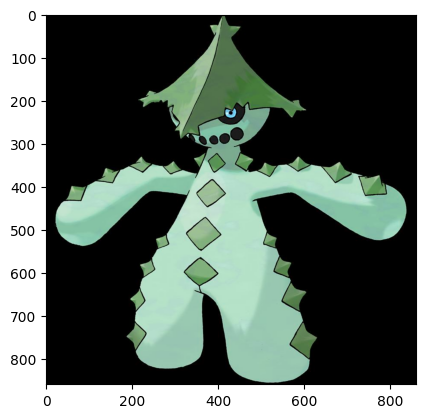

In [41]:
import matplotlib.pyplot as plt
test_example = test_dataset[0]
test_image = test_example[0]
ground_truth = test_example[1]
plt.imshow(test_image)

In [42]:
# prepare image and prompt for the model
# TODO this can be replaced by apply_chat_template when the processor supports this
prompt = f"QUESTION: What Pokémon type is this? <image>\nANSWER: {ground_truth}"
inputs = processor(text=prompt, images=[test_image], return_tensors="pt").to("cuda")
for k,v in inputs.items():
    print(k,v.shape)

input_ids torch.Size([1, 23])
attention_mask torch.Size([1, 23])
pixel_values torch.Size([1, 3, 336, 336])


### Testing

In [45]:
# Generate token IDs
generated_ids = model.generate(**inputs, max_new_tokens=MAX_LENGTH)

# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

In [46]:
print(generated_texts)

['QUESTION: What Pokémon type is this?  \nANSWER: grass']


In [52]:
import torch
import re

# Set the model in evaluation mode
model.eval()

# Initialize variables to track the number of correct predictions and total samples
correct_predictions = 0
total_samples = len(test_dataset)

# Loop over the test dataset
for i in range(total_samples):
    # Get the image and ground truth from the test dataset
    test_example = test_dataset[i]
    test_image = test_example[0]
    ground_truth = test_example[1]

    # Prepare the prompt for the model
    prompt = f"QUESTION: What Pokémon type is this? <image>\nANSWER: {ground_truth}"
    inputs = processor(text=prompt, images=[test_image], return_tensors="pt").to("cuda")

    # Generate token IDs using the model
    generated_ids = model.generate(**inputs, max_new_tokens=MAX_LENGTH)

    # Decode the generated token IDs back into text
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

    # Get the generated text (it's the first one in the list)
    generated_output = generated_texts[0].strip()

    # Use regex to extract the answer part after "ANSWER:"
    match = re.search(r'ANSWER:\s*(.*)', generated_output)
    if match:
        # Extract the answer (strip extra spaces)
        generated_prediction = match.group(1).strip()
    else:
        # If there's no match, just set it as the raw output (in case of any parsing issue)
        generated_prediction = generated_output

    # Only take the first word (if multiple words in the prediction)
    generated_prediction = generated_prediction.split(' ')[0]

    # Print current progress
    print(f"Processing {i+1}/{total_samples} - Ground Truth: {ground_truth}, Prediction: {generated_prediction}")

    # Compare the prediction with the ground truth (case-sensitive comparison)
    if generated_prediction.lower() == ground_truth.lower():
        correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_samples * 100
print(f"Accuracy on the test set: {accuracy:.2f}%")

Processing 1/90 - Ground Truth: grass, Prediction: grass
Processing 2/90 - Ground Truth: rock, Prediction: rock
Processing 3/90 - Ground Truth: normal, Prediction: normal
Processing 4/90 - Ground Truth: electric, Prediction: electric
Processing 5/90 - Ground Truth: normal, Prediction: normal
Processing 6/90 - Ground Truth: ground, Prediction: ground
Processing 7/90 - Ground Truth: steel, Prediction: steel
Processing 8/90 - Ground Truth: normal, Prediction: normal
Processing 9/90 - Ground Truth: fairy, Prediction: fairy
Processing 10/90 - Ground Truth: normal, Prediction: normal
Processing 11/90 - Ground Truth: rock, Prediction: rock
Processing 12/90 - Ground Truth: water, Prediction: water
Processing 13/90 - Ground Truth: normal, Prediction: normal
Processing 14/90 - Ground Truth: dark, Prediction: dark
Processing 15/90 - Ground Truth: fairy, Prediction: fairy
Processing 16/90 - Ground Truth: ground, Prediction: ground
Processing 17/90 - Ground Truth: ice, Prediction: ice
Processing 18